## **Importing Dependencies**

In [1]:
!pip install --upgrade pip
!pip install torchio
!pip install --upgrade torch torchvision monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 37.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 68.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 131.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 132.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 24.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 92.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 94.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 101.8 MB/s e

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import imageio
from IPython.display import display, Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchio as tio 
import SimpleITK as sitk
from monai.metrics import DiceMetric, compute_average_surface_distance, compute_surface_dice
import pandas as pd
from monai.transforms import Compose, Activations, AsDiscrete
import torch.nn as nn
from torchsummary import summary
from monai.losses import DiceLoss, DiceFocalLoss, TverskyLoss, HausdorffDTLoss

## **Visualizing Maps & Label Masks**

### **Support Functions**

In [34]:
# Multi-view of ADC and Z_ADC Maps and Binary Masks (Sample - 302)
def display_3d_image():
    # Load the ADC and Z-ADC maps (stacked in 2 channels)
    adc_zadc_image = sitk.ReadImage("/kaggle/input/bonbid-hie/Preprocessed/Val/MAP/MGHNICU_302-VISIT_01_concatenated.mha")
    adc_image = sitk.GetArrayFromImage(adc_zadc_image)[0]  # First channel (ADC)
    zadc_image = sitk.GetArrayFromImage(adc_zadc_image)[1]  # Second channel (Z-ADC)
    
    # Load the label image
    label_image = sitk.ReadImage("/kaggle/input/bonbid-hie/Preprocessed/Val/LABEL/MGHNICU_302-VISIT_01_lesion.mha")
    label = sitk.GetArrayFromImage(label_image)
    
    # Select a slice to display: Axial, Coronal, and Sagittal (Middle Slice for each)
    axial_slice = adc_image[adc_image.shape[0] // 2]
    coronal_slice = adc_image[:, adc_image.shape[1] // 2, :]
    sagittal_slice = adc_image[:, :, adc_image.shape[2] // 2]
    
    # Plot the images
    fig, axs = plt.subplots(3, 3, figsize=(15, 10))
    
    # ADC slices
    axs[0, 0].imshow(axial_slice, cmap='gray')
    axs[0, 0].set_title("ADC - Sample 302 - Axial")
    axs[0, 1].imshow(coronal_slice, cmap='gray')
    axs[0, 1].set_title("ADC - Sample 302 - Coronal")
    axs[0, 2].imshow(sagittal_slice, cmap='gray')
    axs[0, 2].set_title("ADC - Sample 302 - Sagittal")
    
    # Z-ADC slices
    axs[1, 0].imshow(zadc_image[adc_image.shape[0] // 2], cmap='gray')
    axs[1, 0].set_title("Z-ADC - Sample 302 - Axial")
    axs[1, 1].imshow(zadc_image[:, adc_image.shape[1] // 2, :], cmap='gray')
    axs[1, 1].set_title("Z-ADC - Sample 302 - Coronal")
    axs[1, 2].imshow(zadc_image[:, :, adc_image.shape[2] // 2], cmap='gray')
    axs[1, 2].set_title("Z-ADC - Sample 302 - Sagittal")
    
    # Label slices
    axs[2, 0].imshow(label[adc_image.shape[0] // 2], cmap='Reds')
    axs[2, 0].set_title("Label - Sample 302 - Axial")
    axs[2, 1].imshow(label[:, adc_image.shape[1] // 2, :], cmap='Reds')
    axs[2, 1].set_title("Label - Sample 302 - Coronal")
    axs[2, 2].imshow(label[:, :, adc_image.shape[2] // 2], cmap='Reds')
    axs[2, 2].set_title("Label - Sample 302 - Sagittal")
    
    plt.tight_layout()
    plt.show()

# ADC and Z_ADC Maps with Ground Truth (Validation Samples)
def plot_grid_with_ground_truth():
    fig, axs = plt.subplots(4, 2, figsize=(12, 10))
    
    sample_ids = ['001', '002', '302', '436']
    
    for i, sample_id in enumerate(sample_ids):
        # Load images
        adc_zadc_image = sitk.ReadImage(f"/kaggle/input/bonbid-hie/Preprocessed/Val/MAP/MGHNICU_{sample_id}-VISIT_01_concatenated.mha")
        adc_image = sitk.GetArrayFromImage(adc_zadc_image)[0]  # ADC channel
        zadc_image = sitk.GetArrayFromImage(adc_zadc_image)[1]  # Z-ADC channel
        
        label_image = sitk.ReadImage(f"/kaggle/input/bonbid-hie/Preprocessed/Val/LABEL/MGHNICU_{sample_id}-VISIT_01_lesion.mha")
        label = sitk.GetArrayFromImage(label_image)
        
        # Select middle axial slice
        axial_adc = adc_image[adc_image.shape[0] // 2]
        axial_zadc = zadc_image[adc_image.shape[0] // 2]
        axial_label = label[adc_image.shape[0] // 2]
        
        # ADC with Ground Truth
        axs[i, 0].imshow(axial_adc, cmap='gray')
        axs[i, 0].imshow(axial_label, cmap='Reds', alpha=0.5)
        axs[i, 0].set_title(f"ADC - Sample {sample_id} w/ GT")
        
        # Z-ADC with Ground Truth
        axs[i, 1].imshow(axial_zadc, cmap='gray')
        axs[i, 1].imshow(axial_label, cmap='Reds', alpha=0.5)
        axs[i, 1].set_title(f"Z-ADC - Sample {sample_id} w/ GT")
    
    plt.subplots_adjust(hspace=0.1, wspace=0.01)
    plt.tight_layout()
    plt.show()


# Looping Through Axial Slices (Sample - 302)
def create_gif():
    images = []
    
    # Make sure the directory for saving frames exists
    frame_dir = "/kaggle/working/frames"
    os.makedirs(frame_dir, exist_ok=True)
    
    # Only one sample: MGHNICU_302-VISIT_01
    sample_id = '302'
    
    # Load images
    adc_zadc_image = sitk.ReadImage(f"/kaggle/input/bonbid-hie/Preprocessed/Val/MAP/MGHNICU_{sample_id}-VISIT_01_concatenated.mha")
    adc_image = sitk.GetArrayFromImage(adc_zadc_image)[0]  # ADC channel
    zadc_image = sitk.GetArrayFromImage(adc_zadc_image)[1]  # Z-ADC channel
    
    label_image = sitk.ReadImage(f"/kaggle/input/bonbid-hie/Preprocessed/Val/LABEL/MGHNICU_{sample_id}-VISIT_01_lesion.mha")
    label = sitk.GetArrayFromImage(label_image)
    
    # Loop through all the axial slices (32 slices in total)
    for i in range(adc_image.shape[0]):
        # Select current axial slice
        axial_adc = adc_image[i]
        axial_zadc = zadc_image[i]
        axial_label = label[i]
        
        # Create image with ADC, Z-ADC, and ground truth overlay for current slice
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        
        axs[0].imshow(axial_adc, cmap='gray')
        axs[0].imshow(axial_label, cmap='Reds', alpha=0.5)
        axs[0].set_title(f"ADC - Sample {sample_id} w/ GT - Slice {i+1}")
        
        axs[1].imshow(axial_zadc, cmap='gray')
        axs[1].imshow(axial_label, cmap='Reds', alpha=0.5)
        axs[1].set_title(f"Z-ADC - Sample {sample_id} w/ GT - Slice {i+1}")
        
        plt.tight_layout()
        plt.axis('off')
        
        # Save frame as image
        frame_path = f"{frame_dir}/frame_{i}.png"
        plt.savefig(frame_path)
        plt.close()
        
        images.append(frame_path)
    
    # Create GIF
    gif_path = "/kaggle/working/adc_zadc_gt.gif"
    with imageio.get_writer(gif_path, mode='I', duration=0.00001, loop=0) as writer:
        for image in images:
            writer.append_data(imageio.imread(image))
    
    # Clean up individual frames
    for image in images:
        os.remove(image)
    
    # Display the GIF in the notebook
    display(Image(filename=gif_path))
    
    return gif_path

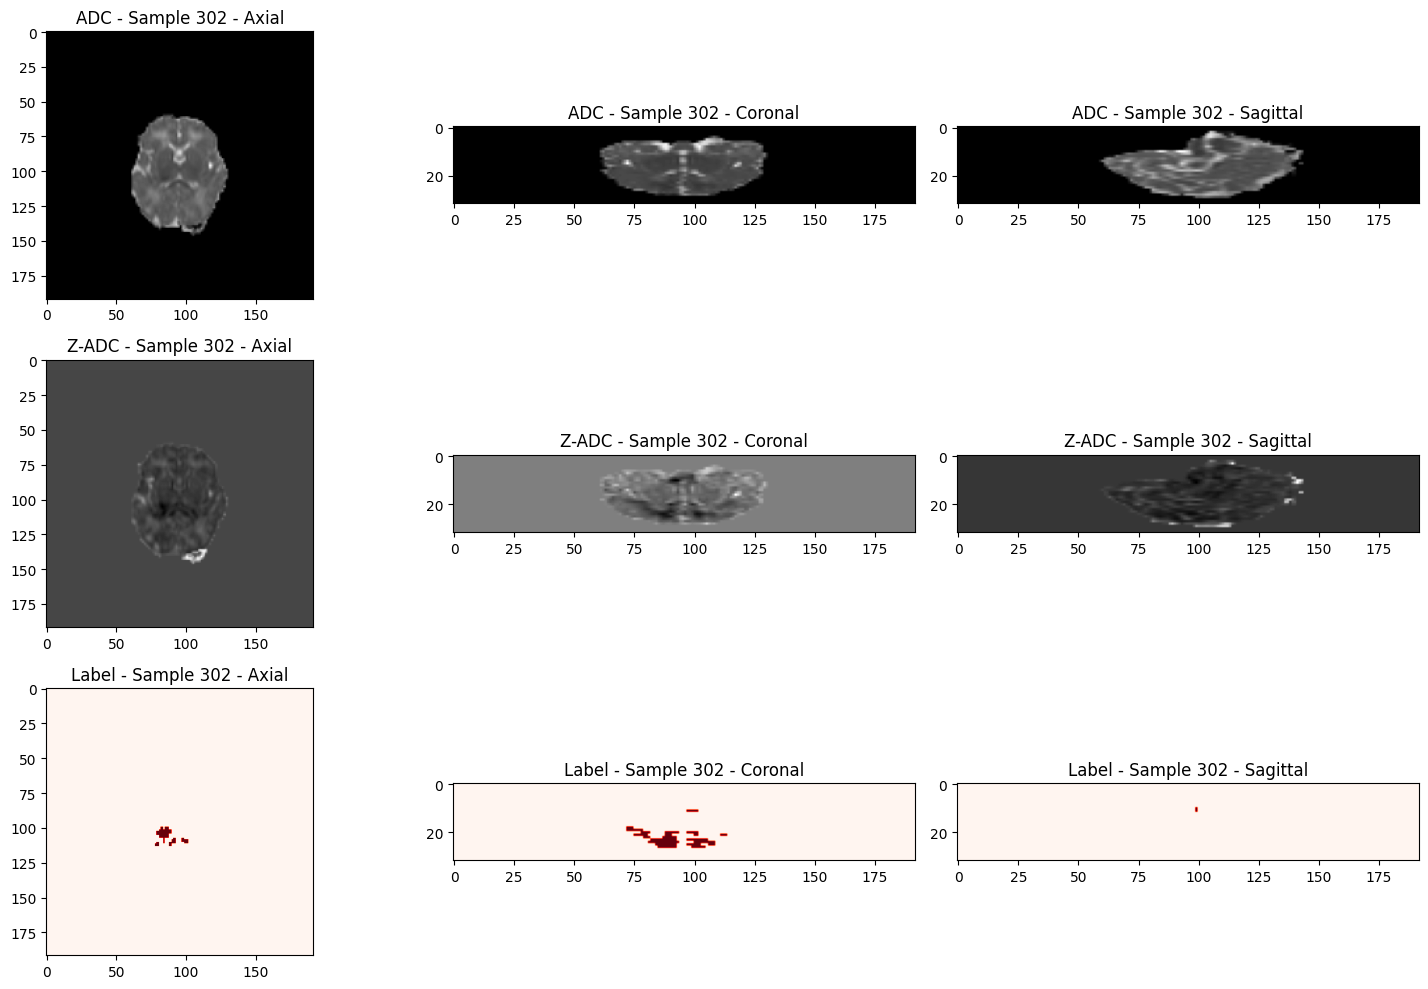

In [35]:
# Multi-view of ADC and Z_ADC Maps and Binary Masks (Sample - 302)
display_3d_image()

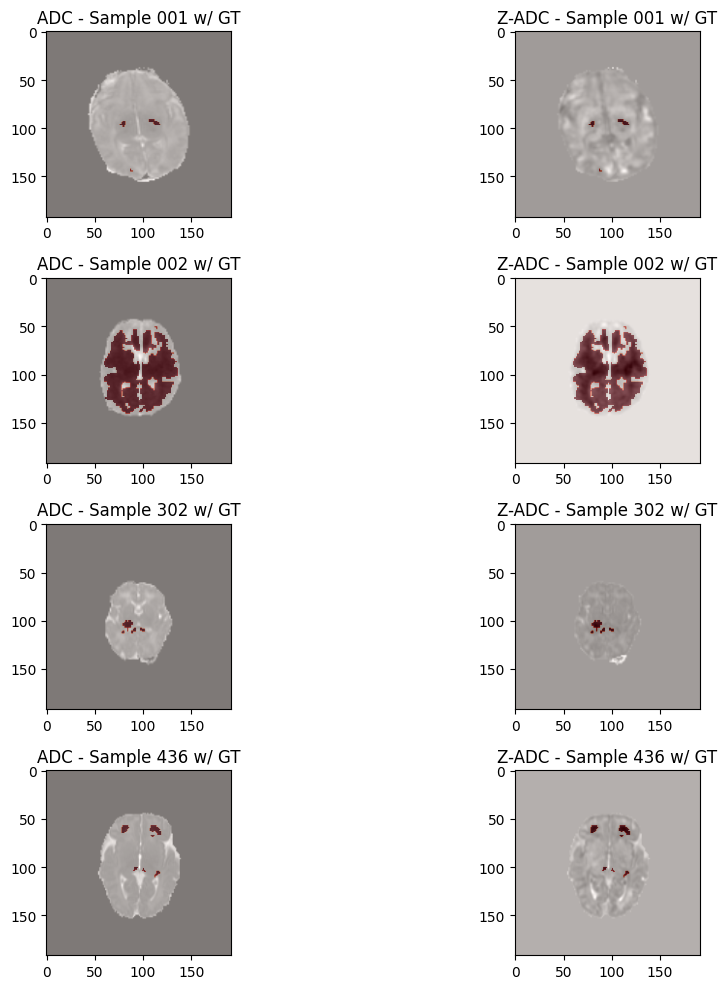

In [36]:
# ADC and Z_ADC Maps with Ground Truth (Validation Samples)
plot_grid_with_ground_truth()

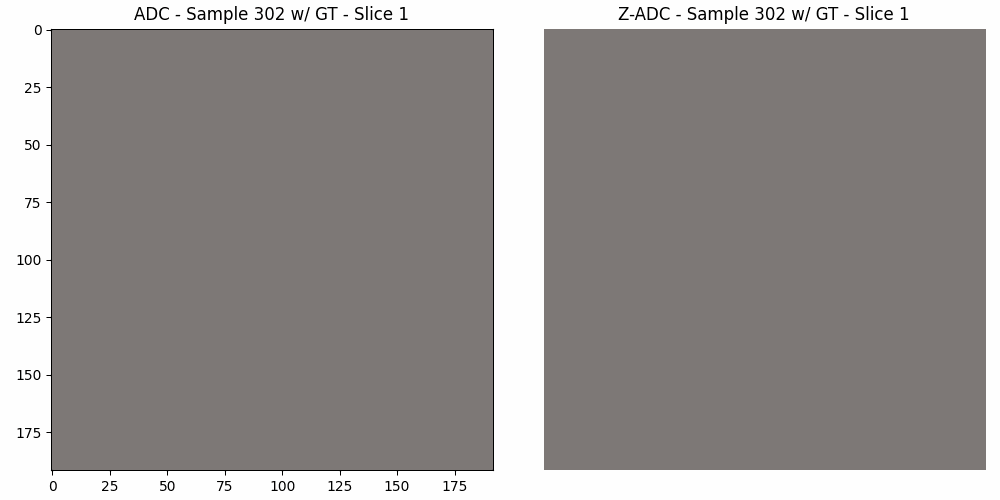

'/kaggle/working/adc_zadc_gt.gif'

In [37]:
# Looping Through Axial Slices (Sample - 302)
create_gif()

## **Data Loading & Augmentation**
* The dataset used here is Part I of BONBID-HIE MICCAI 2023 Challenge. It contains 3d skull stripped Apparent Diffusion Coefficient (ADC) maps, Z-score normalized ADC maps (ZADC), and binary label masks for 133 HIE patients from Massachusetts General Hospital (85 training cases, 4 validation cases, and 44 testing cases - hidden).
* Preprocessed (resampled, normalized, and concatenated) data after running preprocessing notebook is used here. Input is a 2-channel map (C,H,W,D) -> (2,192,192,32) while the output is a single channel binary mask (C,H,W,D) -> (1,192,192,32).
* The network is trained on Nvidia Tesla P100 GPU on Kaggle with a batch size of 4, the maximum feasible size given memory constraints.
* The maps are augmented using the TorchIO library with a probability of 0.5 for each transformation: (i) Random Noise (mean=0.0, std=0.01) simulates realistic scanner artifacts, (ii) Random Anisotropy (downsampling=(1.2, 2.0)) reflects mild-to-moderate real-world variations in image resolution, (iii) Random Blur ((std=(0, 0.5)) addresses scenarios where lesion edges appear blurred due to low resolution or motion artifacts, (iv) Random Gamma (log_gamma=(-0.1, 0.1)) introduces subtle realistic changes to brightness and contrast, and (v) Random Elastic Transformation mimics natural variations in soft tissues caused by patient movement or anatomy. Augmentations are crucial in our case to artificially increase the training dataset size (which is really small), simulate real-world imaging variations for improved generalizability, and ensure scanner invariance in the model.

In [3]:
class BONBIDataset(Dataset):
    def __init__(self, maps_dir, labels_dir, augment=False):
        self.maps_dir = maps_dir
        self.labels_dir = labels_dir
        self.augment = augment

        # Get the case names from the directories
        self.case_names = self._get_cases_from_dir(maps_dir)

        if self.augment:
            self.image_transforms = tio.Compose([
                tio.RandomNoise(mean=0.0, std=0.01, p=0.5),
                tio.RandomAnisotropy(downsampling=(1.2, 2.0), p=0.5),
                tio.RandomBlur(std=(0, 0.5), p=0.5),
                tio.RandomGamma(log_gamma=(-0.1, 0.1), p=0.5),
                tio.RandomElasticDeformation(p=0.5)
            ])

    def _get_cases_from_dir(self, dir_path):
        case_names = []
        for filename in os.listdir(dir_path):
            if filename.endswith('_concatenated.mha'):  
                case_name = "_".join(filename.split('_')[:3]) 
                case_names.append(case_name)
        return list(case_names)  # Convert set to list

    def __len__(self):
        return len(self.case_names)

    def __getitem__(self, idx):
        case_name = self.case_names[idx]
        map_path = os.path.join(self.maps_dir, f"{case_name}_concatenated.mha")
        label_path = os.path.join(self.labels_dir, f"{case_name}_lesion.mha")

        # Load the images using SimpleITK
        map_img = sitk.GetArrayFromImage(sitk.ReadImage(map_path))  # Shape: (C, D, H, W)
        label_img = sitk.GetArrayFromImage(sitk.ReadImage(label_path))  # Shape: (D, H, W)

        map_tensor = torch.from_numpy(map_img).float()  # (C, D, H, W)
        label_tensor = torch.from_numpy(label_img).long().unsqueeze(0)  # (1, D, H, W)

        if self.augment:
            map_tensor = self.image_transforms(tio.ScalarImage(tensor=map_tensor)).tensor

        return map_tensor, label_tensor

In [4]:
# Paths for data directories
train_maps_dir = "/kaggle/input/bonbid-hie/Preprocessed/Train/MAP"
train_label_dir = "/kaggle/input/bonbid-hie/Preprocessed/Train/LABEL"
val_maps_dir = "/kaggle/input/bonbid-hie/Preprocessed/Val/MAP"
val_label_dir = "/kaggle/input/bonbid-hie/Preprocessed/Val/LABEL"

In [5]:
# Create Datasets
train_dataset = BONBIDataset(train_maps_dir, train_label_dir, augment=True)
val_dataset = BONBIDataset(val_maps_dir, val_label_dir, augment=False)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=8)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

train_sample = next(iter(train_loader))  
train_map, train_label = train_sample    
print("Training Sample Shape:")
print(f"Map Shape (Image): {train_map.data.shape}") 
print(f"Label Shape: {train_label.shape}")      

val_sample = next(iter(val_loader))  
val_map, val_label = val_sample      
print("\nValidation Sample Shape:")
print(f"Map Shape (Image): {val_map.data.shape}")  
print(f"Label Shape: {val_label.shape}")   

Number of training samples: 85
Number of validation samples: 4
Training Sample Shape:
Map Shape (Image): torch.Size([4, 2, 32, 192, 192])
Label Shape: torch.Size([4, 1, 32, 192, 192])

Validation Sample Shape:
Map Shape (Image): torch.Size([4, 2, 32, 192, 192])
Label Shape: torch.Size([4, 1, 32, 192, 192])


## **Training & Inference**
* Training is capped at 100 epochs, with early stopping enabled to halt training after 10 epochs with no improvement.
* To improve generalization and prevent overfitting due to the limited dataset size, the AdamW optimizer is used. Unlike the original Adam where weight decay is implicitly tied to the learning rate, AdamW explicitly applies weight decay by subtracting a penalty (multiple of the weights) during parameter update, which encourages smaller weights and smoother decision boundaries. A weight decay rate of 1e-3 balances simplicity with sufficient model capacity and complements the small batch size by countering the risk of overfitting due to noisy gradient updates.
* The learning rate is set to 1e-3, with exponential decay (factor of 0.9) for faster convergence and reduced oscillations in later epochs.
* L1 regularization (1e-4) promotes sparsity in the model, reducing overfitting.
* Gradient clipping (max norm = 1) is applied to prevent gradient explosion, which is crucial for deep architectures like U-Net.
* These strategies—dropout, weight decay, L1 regularization, and gradient clipping—help stabilize training, reduce overfitting, and enhance generalizability.

In [5]:
# Train Function
def train(
    model,
    loss_criterion,
    train_loader,
    val_loader,
    num_epochs=50,
    patience=5,
    lr=1e-3,
    weight_decay=1e-2,
    l1_lambda=1e-5,
    max_grad_norm=1.0,
    gamma=0.95,
    show_output=True,
):
    # Optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    best_val_loss = float("inf")
    patience_counter = 0
    train_losses, val_losses = [], []
    best_model_wts = None
    best_metrics = {
        "train_loss": None,
        "val_loss": None
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_samples = 0

        for maps, labels in train_loader:
            # Move data to GPU
            maps, labels = maps.to(device), labels.to(device)

            # Forward pass
            outputs = model(maps)

            # Compute loss with L1 regularization
            l1_reg = sum(param.abs().sum() for param in model.parameters())
            loss = loss_criterion(outputs, labels) + l1_lambda * l1_reg

            # Backward pass
            loss.backward()

            # Update metrics
            running_loss += loss.item()
            train_samples += outputs.size(0)

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)

            # Optimizer step
            optimizer.step()
            optimizer.zero_grad()

        # Calculate average metrics for training
        avg_train_loss = running_loss / train_samples
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_samples = 0

        with torch.no_grad():
            for val_maps, val_labels in val_loader:
                # Move data to GPU
                val_maps, val_labels = val_maps.to(device), val_labels.to(device)

                val_outputs = model(val_maps)

                # Compute loss
                val_loss += loss_criterion(val_outputs, val_labels).item()
                val_samples += val_outputs.size(0)

        avg_val_loss = val_loss / val_samples

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_metrics = {
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss
            }
            best_model_wts = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        # Step scheduler
        scheduler.step()

        # Print metrics
        if show_output and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot losses
    fig, ax1 = plt.subplots()

    # Plot Train Loss on the left y-axis
    ax1.plot(range(len(train_losses)), train_losses, label="Train Loss", color='tab:blue')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Train Loss", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create a second y-axis for Validation Loss
    ax2 = ax1.twinx()
    ax2.plot(range(len(val_losses)), val_losses, label="Validation Loss", color='tab:orange')
    ax2.set_ylabel("Validation Loss", color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Add a legend
    fig.legend(loc="upper right")

    # Show the plot
    plt.show()

    return model, best_metrics

In [6]:
# Inference Function
def inference(model, val_loader):
    model.eval()
    post_pred = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
    
    results = []

    with torch.no_grad():
        for batch_idx, (val_maps, val_labels) in enumerate(val_loader):
            # Move data to device
            val_maps, val_labels = val_maps.to(device), val_labels.to(device)

            # Forward pass
            logits = model(val_maps)
            prob_masks = torch.sigmoid(logits)  # Probability mask
            binarized_masks = post_pred(logits)  # Binarized mask

            # Process each example in the batch
            for i in range(val_maps.shape[0]):  # Iterate over batch size
                adc = val_maps[i, 0, :, :, :]  # First channel: ADC
                z_adc = val_maps[i, 1, :, :, :]  # Second channel: Z_ADC
                gt_label = val_labels[i:i+1]  # Ground truth label (keep batch dim for metrics)
                pred_label = binarized_masks[i:i+1]  # Predicted label (keep batch dim for metrics)

                # Compute Dice for this sample
                dice_metric = DiceMetric()
                dice_metric(y_pred=pred_label, y=gt_label)
                dice_score = dice_metric.aggregate().item()
                dice_metric.reset()

                # Convert to CPU/NumPy for MSD and NSD
                binarized_np = pred_label
                labels_np = gt_label

                # Compute MSD
                msd = compute_average_surface_distance(y_pred=binarized_np, y=labels_np)
                mean_msd = msd.item()  # Mean across all structures

                # Compute NSD
                nsd = compute_surface_dice(y_pred=binarized_np, y=labels_np, class_thresholds=[1.0])
                mean_nsd = nsd.item()  # Mean across all structures

                # Append results
                results.append({"DICE": dice_score, "MSD": mean_msd, "NSD": mean_nsd})

                # Squeeze the redundant dimensions for labels
                gt_label = gt_label.squeeze(0).squeeze(0)  # Remove batch and channel dimensions
                pred_label = pred_label.squeeze(0).squeeze(0)  # Remove batch and channel dimensions

                # Visualization for axial slices
                axial_idx = adc.shape[0] // 2  # Middle axial slice
                fig, axes = plt.subplots(1, 4, figsize=(16, 4))

                # Plot ADC with ground truth
                axes[0].imshow(adc[axial_idx, :, :].cpu().numpy(), cmap='gray')
                axes[0].imshow(gt_label[axial_idx, :, :].cpu().numpy(), alpha=0.5, cmap='Reds')
                axes[0].set_title("ADC + GT")

                # Plot ADC with predicted label
                axes[1].imshow(adc[axial_idx, :, :].cpu().numpy(), cmap='gray')
                axes[1].imshow(pred_label[axial_idx, :, :].cpu().numpy(), alpha=0.5, cmap='Reds')
                axes[1].set_title("ADC + Pred")

                # Plot Z_ADC with ground truth
                axes[2].imshow(z_adc[axial_idx, :, :].cpu().numpy(), cmap='gray')
                axes[2].imshow(gt_label[axial_idx, :, :].cpu().numpy(), alpha=0.5, cmap='Reds')
                axes[2].set_title("Z_ADC + GT")

                # Plot Z_ADC with predicted label
                axes[3].imshow(z_adc[axial_idx, :, :].cpu().numpy(), cmap='gray')
                axes[3].imshow(pred_label[axial_idx, :, :].cpu().numpy(), alpha=0.5, cmap='Reds')
                axes[3].set_title("Z_ADC + Pred")

                for ax in axes:
                    ax.axis("off")
                plt.tight_layout()
                plt.show()

    # Convert results to a DataFrame
    metrics_df = pd.DataFrame(results,index=['Sample 1','Sample 2','Sample 3','Sample 4'])
    return metrics_df

## **Model Specification**
* We’ve specified a 3D UNet architecture instead of employing more recent architectures like ViTs, which generally require larger datasets to realize their advantages. UNet, with its strong inductive bias of locality, is better suited.
* Our design includes three encoder and decoder blocks instead of the conventional four, reducing depth and parameter count to prevent overfitting given the limited dataset size.
* Each encoder block consists of double 3D convolutional (conv) layers followed by batch normalization, LeakyReLU activation, and dropout, concluding with a maxpooling layer for down-sampling.
* The bottleneck further enhances feature representations through additional double conv layers.
* The decoder progressively up-samples using transpose convolutions, integrates encoder features via skip connections, and then applies double conv layers.
* The output layer employs a (1,1,1) convolution to generate the segmentation map.
* We’ve used complete 2-channel input, combining ADC and ZADC maps, rather than single channel patches to leverage global context and multimodal information for HIE lesion segmentation.
* Batch normalization ensures faster and more stable learning, while dropout minimizes overfitting, with progressively higher rates in deeper layers to encourage independent feature learning across activation maps at higher levels.
* LeakyReLU maintains a small gradient for negative inputs, ensuring gradient flow through non-lesion areas and enabling the model to learn from both lesion and background regions, which is crucial for sparse lesion segmentation.
* He uniform initialization is used in our model to prevent vanishing/exploding gradients by setting the weights to values drawn from a uniform distribution scaled by the number of input units, which is especially effective with ReLU-based activations like LeakyReLU in deep networks, ensuring stable and efficient training.

In [7]:
class DoubleConv3D(nn.Module):
    """(Conv3D => BatchNorm => LeakyReLU => Dropout) * 2"""
    def __init__(self, in_channels, out_channels, dropout_prob=0.2):
        super(DoubleConv3D, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Dropout3d(p=dropout_prob),  
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Dropout3d(p=dropout_prob) 
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()

        # Encoder
        self.enc1 = DoubleConv3D(in_channels, 32, 0.1)
        self.enc2 = DoubleConv3D(32, 64, 0.2)
        self.enc3 = DoubleConv3D(64, 128, 0.2)

        # Downsampling layers
        self.pool = nn.MaxPool3d(2)

        # Bottleneck
        self.bottleneck = DoubleConv3D(128, 256, 0.3)

        # Decoder
        self.upconv3 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.dec3 = DoubleConv3D(256, 128, 0.2)
        
        self.upconv2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.dec2 = DoubleConv3D(128, 64, 0.2)

        self.upconv1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.dec1 = DoubleConv3D(64, 32, 0.1)

        # Output layer
        self.out_conv = nn.Conv3d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc3))

        # Decoder
        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        # Output
        return self.out_conv(dec1)

In [8]:
# Define model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D(in_channels=2, out_channels=1).to(device)

summary(model, input_size=(2, 32, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 32, 32, 192, 192]           1,760
       BatchNorm3d-2     [-1, 32, 32, 192, 192]              64
         LeakyReLU-3     [-1, 32, 32, 192, 192]               0
         Dropout3d-4     [-1, 32, 32, 192, 192]               0
            Conv3d-5     [-1, 32, 32, 192, 192]          27,680
       BatchNorm3d-6     [-1, 32, 32, 192, 192]              64
         LeakyReLU-7     [-1, 32, 32, 192, 192]               0
         Dropout3d-8     [-1, 32, 32, 192, 192]               0
      DoubleConv3D-9     [-1, 32, 32, 192, 192]               0
        MaxPool3d-10       [-1, 32, 16, 96, 96]               0
           Conv3d-11       [-1, 64, 16, 96, 96]          55,360
      BatchNorm3d-12       [-1, 64, 16, 96, 96]             128
        LeakyReLU-13       [-1, 64, 16, 96, 96]               0
        Dropout3d-14       [-1, 64, 16,

In [9]:
# Weight Initialization (he_uniform)

def initialize_weights_he_uniform(layer):
    if isinstance(layer, torch.nn.Conv3d):
        torch.nn.init.kaiming_uniform_(layer.weight, nonlinearity='leaky_relu')
        if layer.bias is not None:
            torch.nn.init.zeros_(layer.bias)
    elif isinstance(layer, torch.nn.BatchNorm3d):
        torch.nn.init.ones_(layer.weight)
        torch.nn.init.zeros_(layer.bias)

model.apply(initialize_weights_he_uniform)

UNet3D(
  (enc1): DoubleConv3D(
    (double_conv): Sequential(
      (0): Conv3d(2, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Dropout3d(p=0.1, inplace=False)
      (4): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01, inplace=True)
      (7): Dropout3d(p=0.1, inplace=False)
    )
  )
  (enc2): DoubleConv3D(
    (double_conv): Sequential(
      (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Dropout3d(p=0.2, inplace=False)
      (4): Conv3d(64, 64, kernel_size=(3, 3, 

## **Loss Function Optimization**
In this study we’ve compared the segmentation performance over various loss functions defined below:

* Dice Loss: It’s used to measure the similarity between two sets.
* Dice Focal Loss (DFL): Dice Focal Loss combines both the Dice Loss and Focal Loss, focusing on hard-to-classify examples.
* Tversky Loss: Tversky Loss is a generalization of Dice loss and is useful in dealing with class imbalances, particularly when false positives and false negatives need to be weighted differently.
* Hausdorff Distance Loss (HDTL): Hausdorff Distance is a measure of the maximum distance between two sets. In segmentation, it's used to measure how far apart the predicted and true boundaries are. Hausdorff Distance Loss is the reciprocal of this value to minimize the distance. This ensures the loss is small when the boundaries are close and large when the boundaries are far apart.
* We also defined two hybrid loss functions. One is a linear combination of Dice-Focal and Hausdorff Distance Loss while the other is a linear combination of Tversky and Hausdorff Distance Loss. Through first combination the aim is to strengthen Dice-Focal Loss’s ability to segment lesions of varying sizes by incorporating Hausdorff Distance Loss for improved boundary precision. While, for the second combination the aim is to merge Tversky Loss’s strength in capturing large lesions with Hausdorff Distance Loss’s ability to capture precise boundaries.

Note: Please refer to the research paper for more details!

### **Dice Loss**

Epoch 10 - Train Loss: 0.2931, Val Loss: 0.1873
Epoch 20 - Train Loss: 0.2794, Val Loss: 0.1665
Epoch 30 - Train Loss: 0.2773, Val Loss: 0.1741
Early stopping at epoch 32


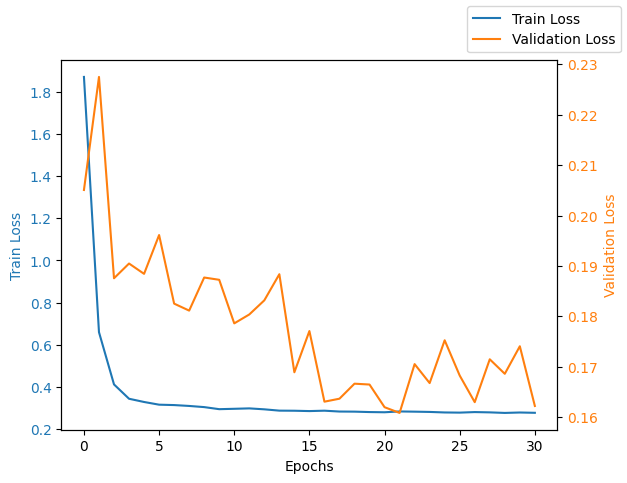

In [12]:
# Train the model
loss_criterion=DiceLoss(sigmoid=True, include_background=False)
best_model, _ = train(
    model=model,
    loss_criterion=loss_criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=100,
    patience=10,
    lr=1e-3,
    weight_decay=1e-3,
    l1_lambda=1e-4,
    max_grad_norm=1.0,
    gamma=0.90,
    show_output=True,
)

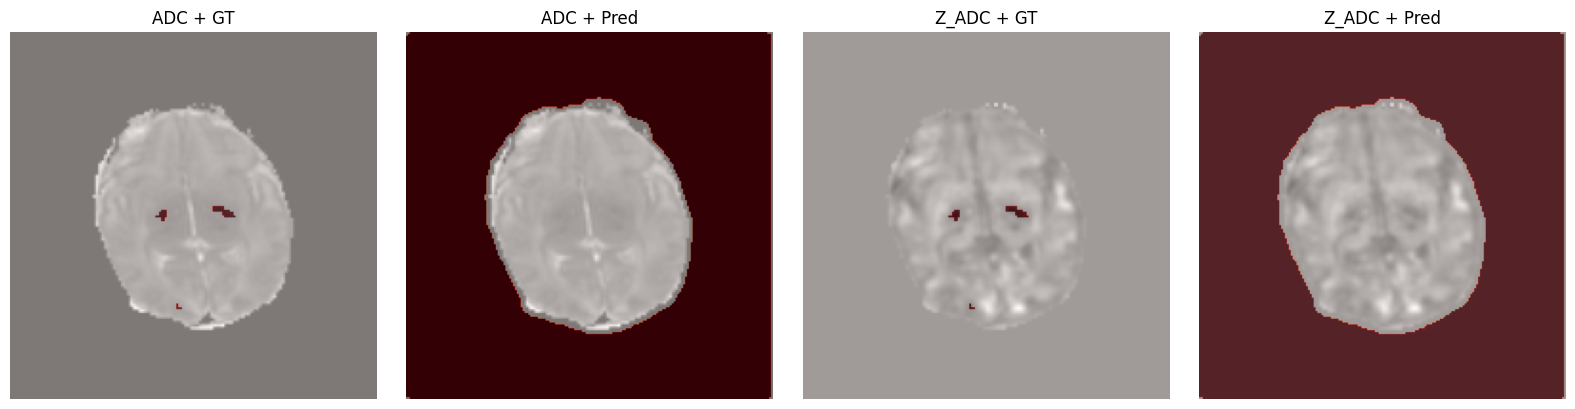

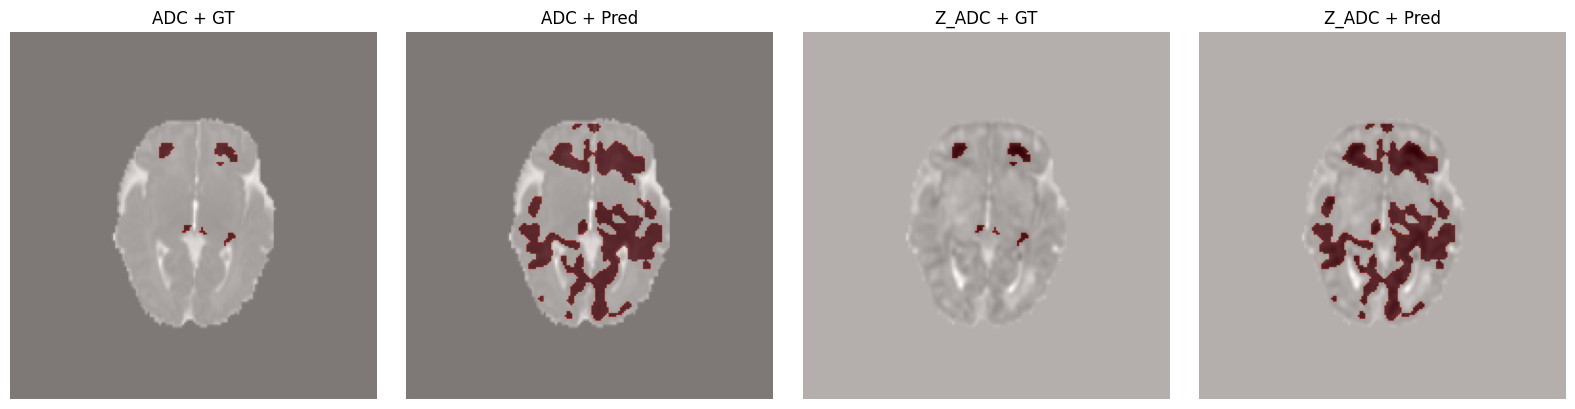

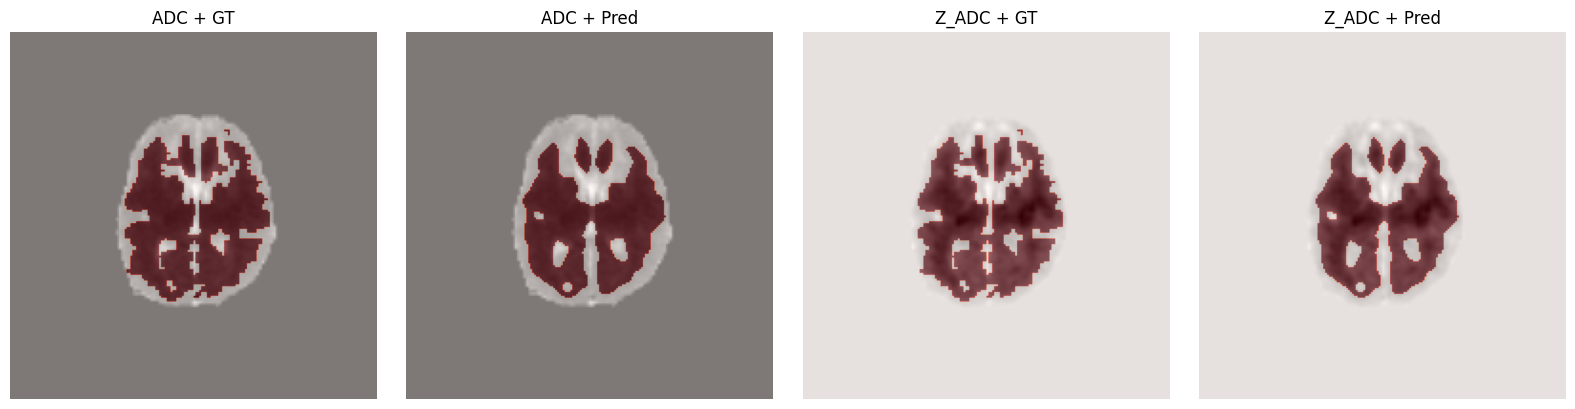

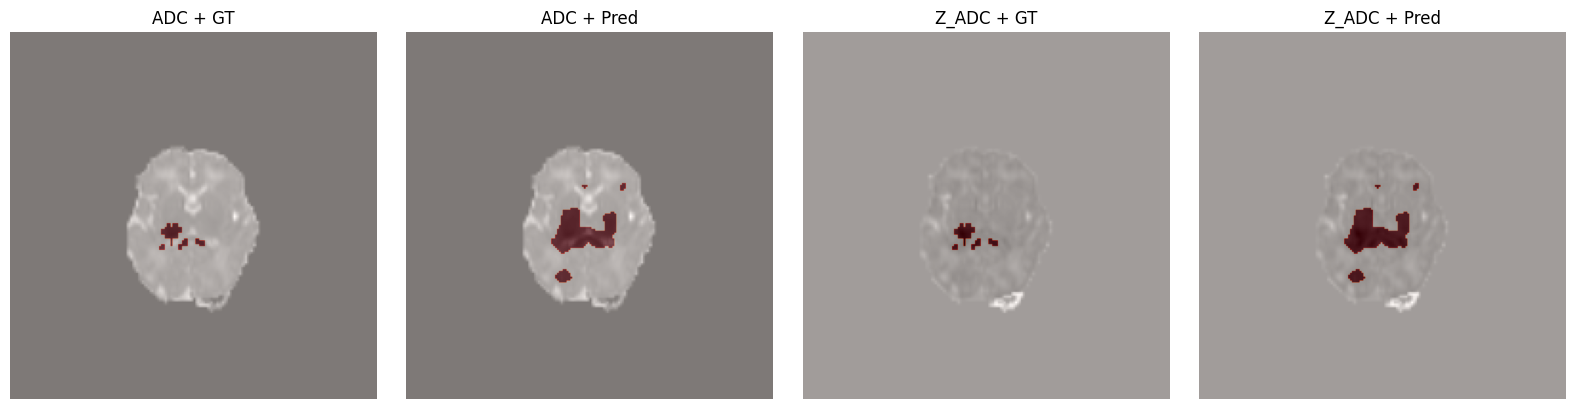

In [13]:
dice_metrics_df=inference(best_model, val_loader)

In [14]:
dice_metrics_df

DICE        MSD       NSD
Sample 1  0.000901  52.598789  0.009429
Sample 2  0.162371   5.153530  0.219895
Sample 3  0.886105   0.512114  0.810880
Sample 4  0.470524   1.995131  0.497793

### **Dice Focal Loss**

Epoch 10 - Train Loss: 0.3094, Val Loss: 0.1798
Epoch 20 - Train Loss: 0.2853, Val Loss: 0.1641
Epoch 30 - Train Loss: 0.2813, Val Loss: 0.1615
Epoch 40 - Train Loss: 0.2749, Val Loss: 0.1577
Early stopping at epoch 49


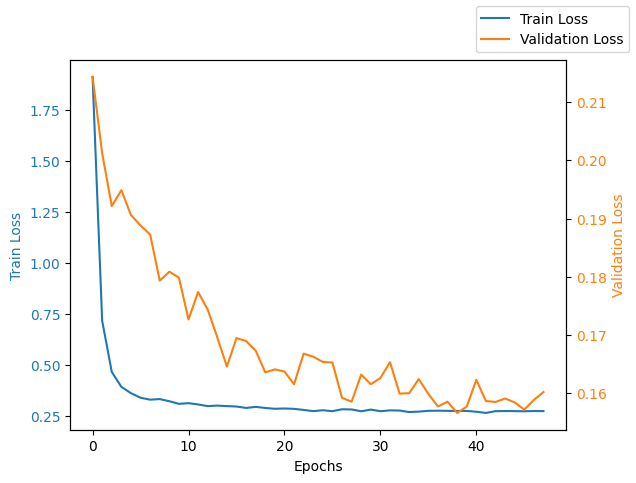

In [11]:
# Train the model
loss_criterion=DiceFocalLoss(sigmoid=True, include_background=False)
best_model, _ = train(
    model=model,
    loss_criterion=loss_criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=100,
    patience=10,
    lr=1e-3,
    weight_decay=1e-3,
    l1_lambda=1e-4,
    max_grad_norm=1.0,
    gamma=0.90,
    show_output=True,
)

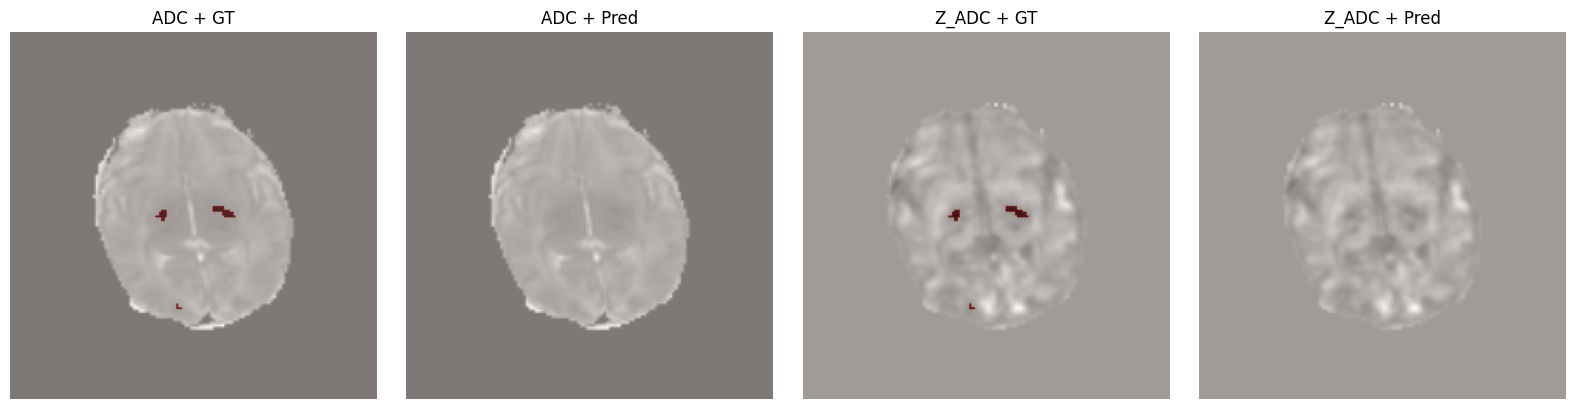

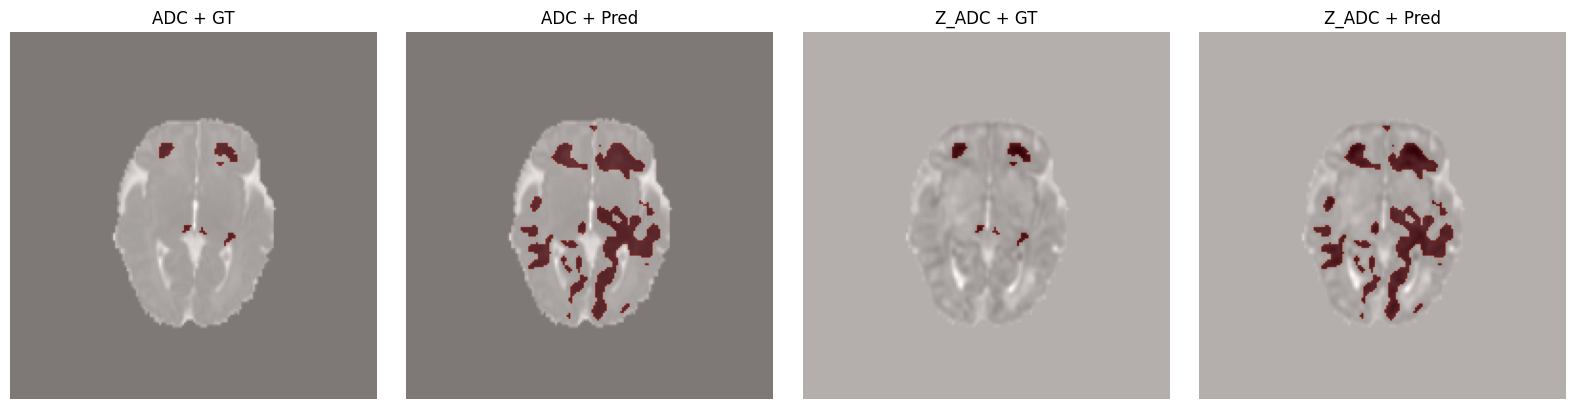

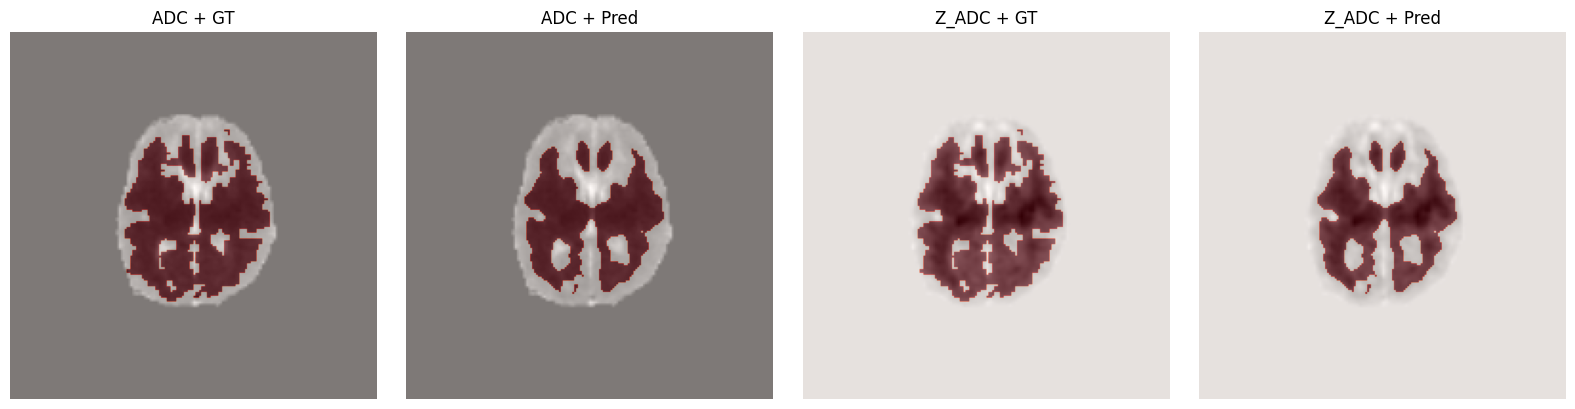

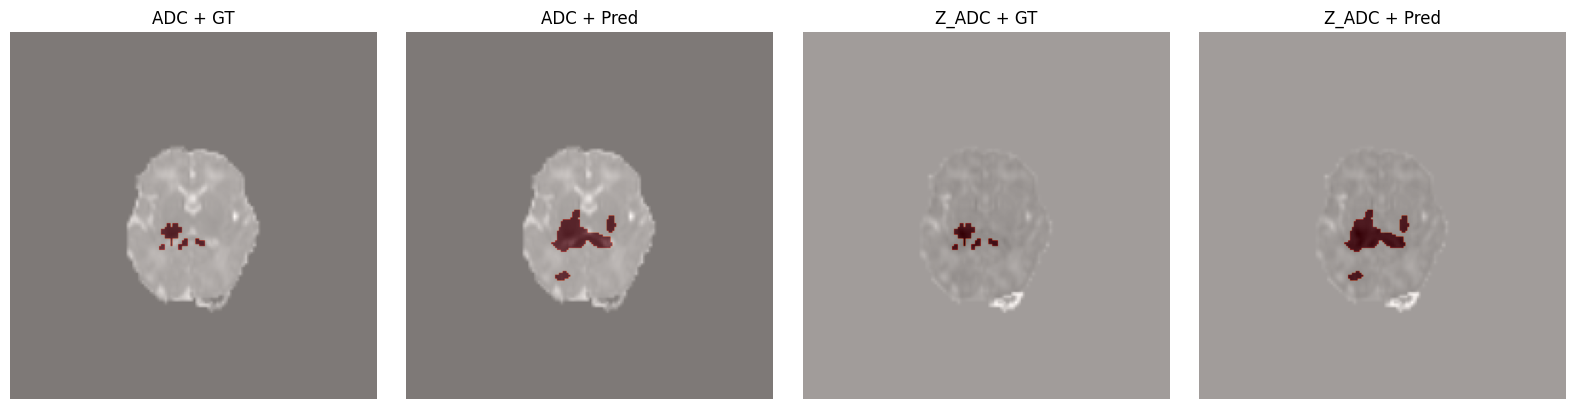

In [14]:
DF_metrics_df=inference(best_model, val_loader)

In [15]:
DF_metrics_df

DICE       MSD       NSD
Sample 1  0.338358  0.552555  0.464713
Sample 2  0.217068  4.441073  0.321437
Sample 3  0.828033  0.743528  0.671071
Sample 4  0.569147  1.435830  0.651831

### **Tversky Loss**

Epoch 10 - Train Loss: 0.2884, Val Loss: 0.1836
Epoch 20 - Train Loss: 0.2743, Val Loss: 0.1718
Epoch 30 - Train Loss: 0.2640, Val Loss: 0.1765
Early stopping at epoch 38


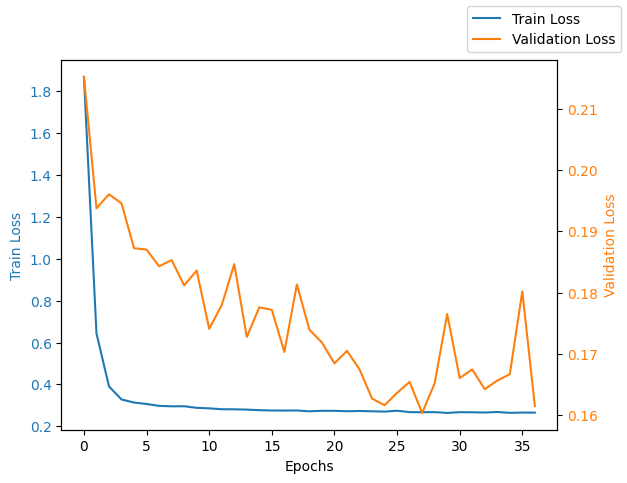

In [12]:
# Train the model
loss_criterion=TverskyLoss(sigmoid=True, alpha=0.3, beta=0.7, include_background=False)
best_model, _ = train(
    model=model,
    loss_criterion=loss_criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=100,
    patience=10,
    lr=1e-3,
    weight_decay=1e-3,
    l1_lambda=1e-4,
    max_grad_norm=1.0,
    gamma=0.90,
    show_output=True,
)

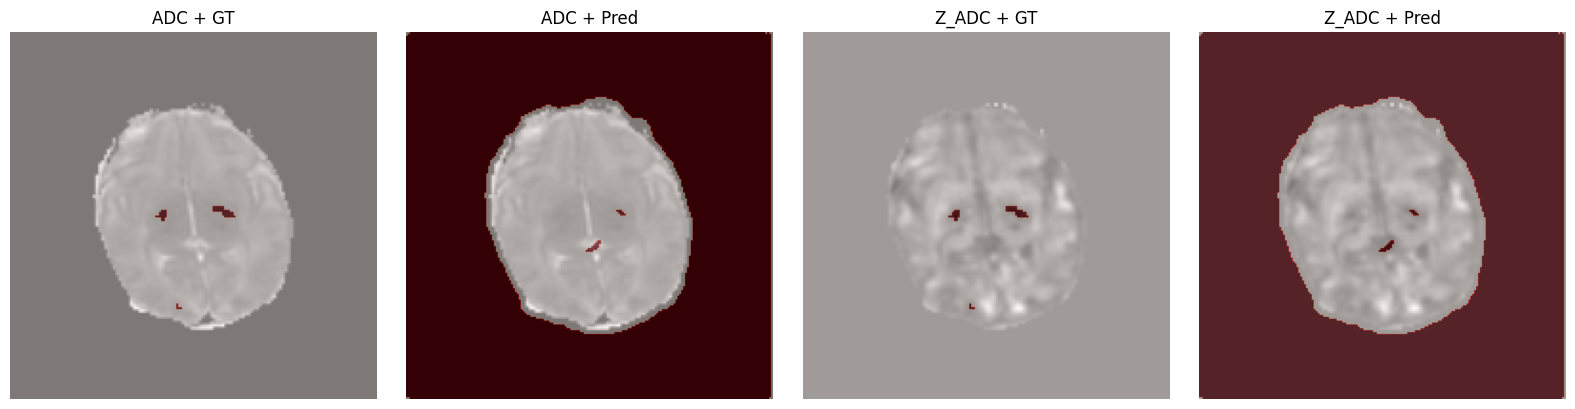

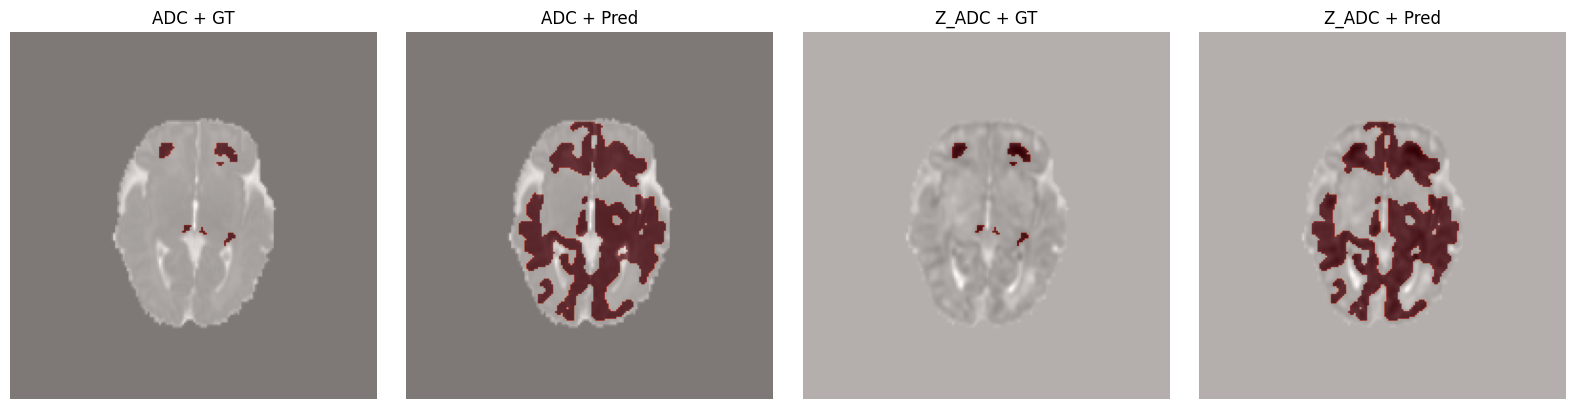

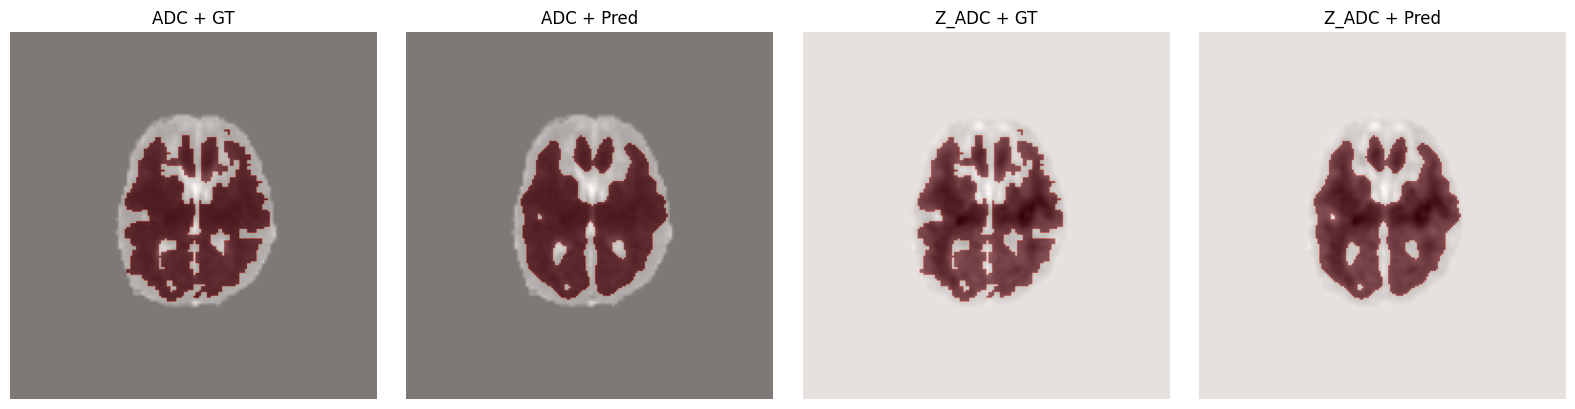

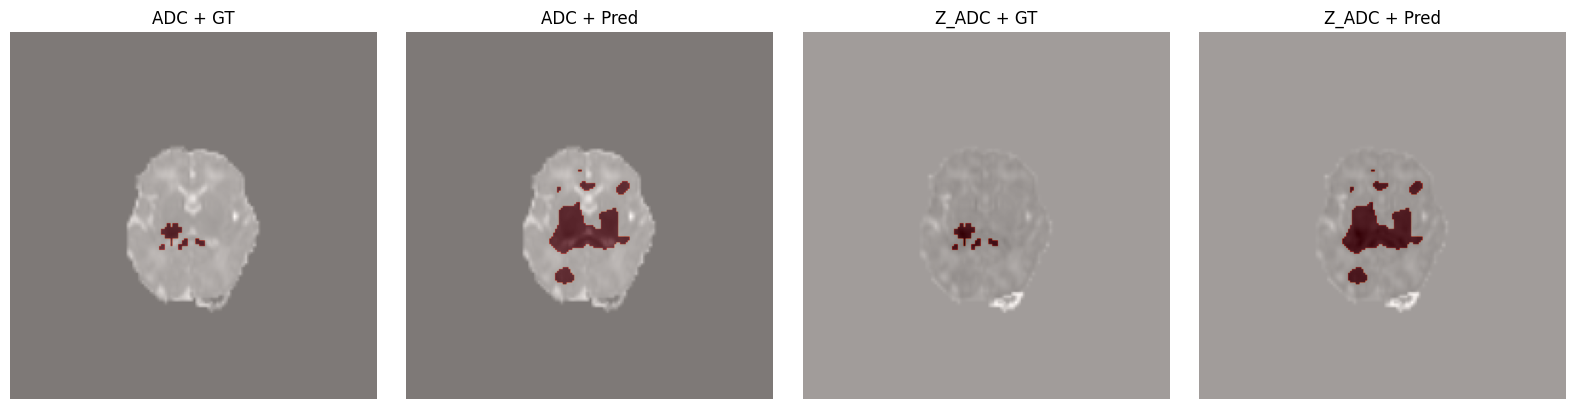

In [13]:
Tv_metrics_df=inference(best_model, val_loader)

In [14]:
Tv_metrics_df

DICE        MSD       NSD
Sample 1  0.001291  52.145607  0.012673
Sample 2  0.116477   5.926050  0.139350
Sample 3  0.916622   0.399786  0.865593
Sample 4  0.365553   2.980631  0.325758

### **Hausdorff Distance(DT) Loss**

In [10]:
# Slightly reduced batch size due to memory constraints
# Create Datasets
train_dataset = BONBIDataset(train_maps_dir, train_label_dir, augment=True)
val_dataset = BONBIDataset(val_maps_dir, val_label_dir, augment=False)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False, num_workers=8)

Epoch 10 - Train Loss: 3.4702, Val Loss: 0.7713
Epoch 20 - Train Loss: 0.9114, Val Loss: 0.1727
Early stopping at epoch 29


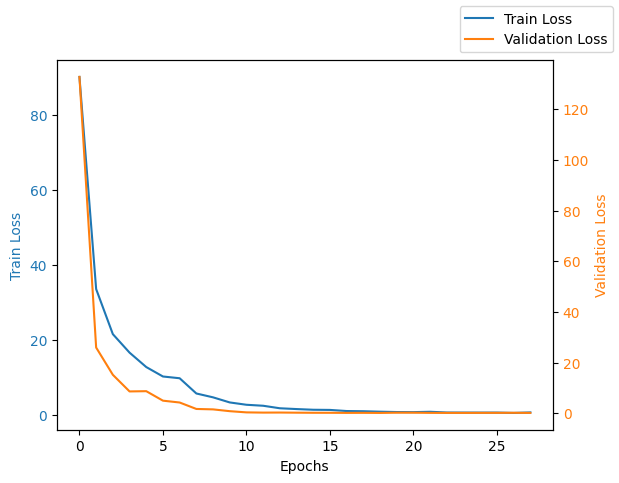

In [11]:
# Train the model
loss_criterion=HausdorffDTLoss(sigmoid=True, include_background=False)
best_model, _ = train(
    model=model,
    loss_criterion=loss_criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=100,
    patience=10,
    lr=1e-3,
    weight_decay=1e-3,
    l1_lambda=1e-4,
    max_grad_norm=1.0,
    gamma=0.90,
    show_output=True,
)

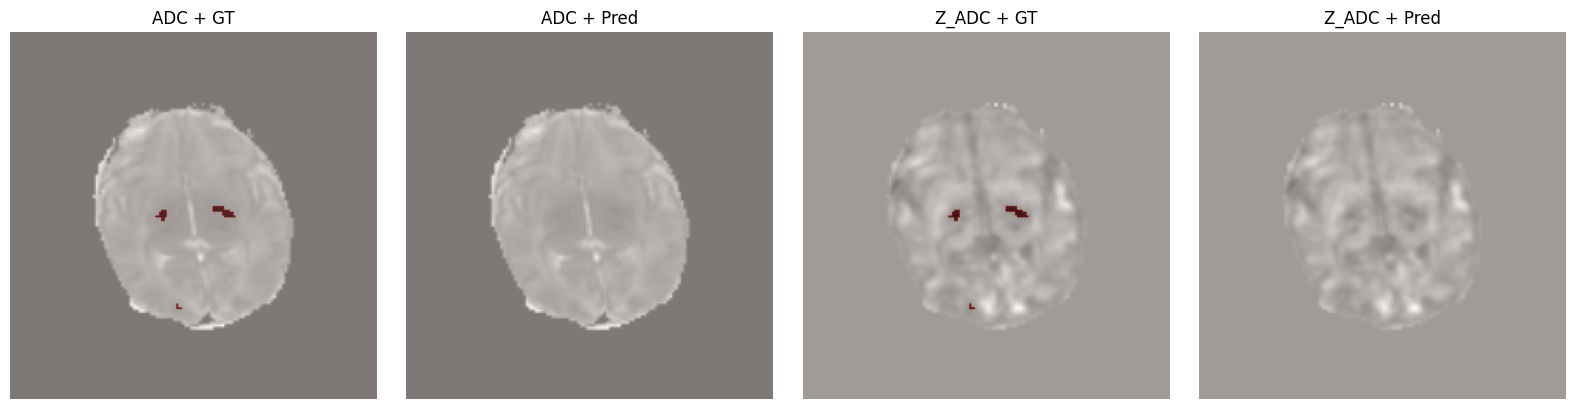

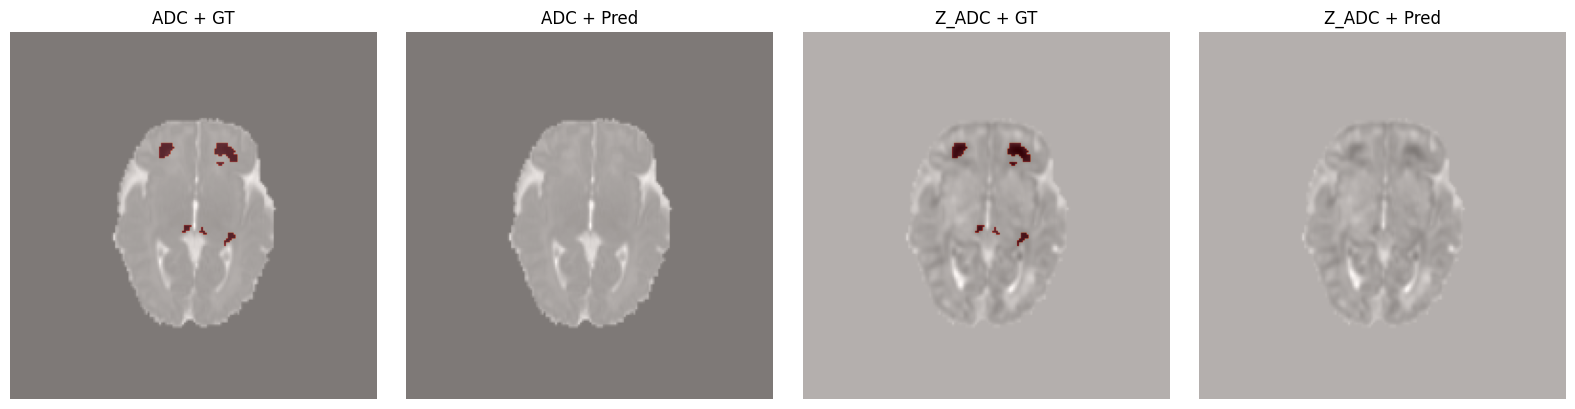

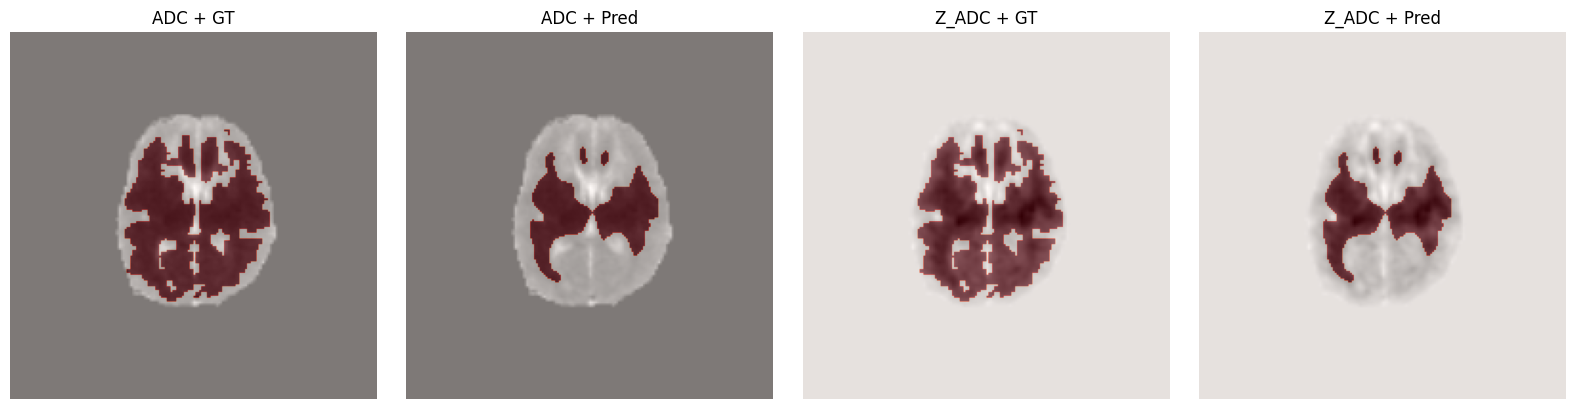

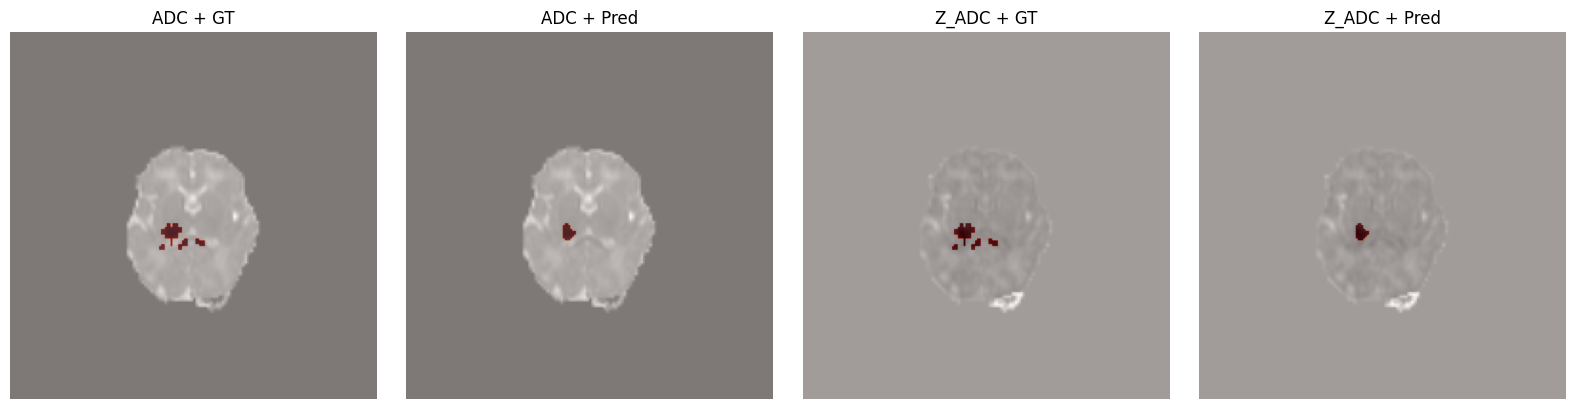

In [12]:
HDT_metrics_df=inference(best_model, val_loader)

In [14]:
HDT_metrics_df

DICE       MSD       NSD
Sample 1  0.000000       inf  0.000000
Sample 2  0.242073  1.214580  0.335110
Sample 3  0.602520  1.436606  0.234785
Sample 4  0.482727  0.517709  0.542533

### **DiceFocal+HausdorffDT Loss**

In [10]:
# Combined Loss Function
class DiceFocalHausdorffDTLoss(torch.nn.Module):
    def __init__(self, lambda_dfl=1.0, lambda_hausdorff=1.0, include_background=False, sigmoid=True):
        super(DiceFocalHausdorffDTLoss, self).__init__()
        self.dfl = DiceFocalLoss(
            sigmoid=sigmoid,
            include_background=include_background
        )
        self.hausdorff = HausdorffDTLoss(
            sigmoid=sigmoid, include_background=include_background
        )
        self.lambda_dfl = lambda_dfl
        self.lambda_hausdorff = lambda_hausdorff

    def forward(self, prediction, target):
        dfl_loss = self.dfl(prediction, target)
        hausdorff_loss = self.hausdorff(prediction, target)
        log_hausdorff_loss = torch.log(1 + hausdorff_loss)

        total_loss = (
            self.lambda_dfl * dfl_loss + self.lambda_hausdorff * log_hausdorff_loss
        )
        return total_loss

In [11]:
# Reduced batch size due to memory constraints
# Create Datasets
train_dataset = BONBIDataset(train_maps_dir, train_label_dir, augment=True)
val_dataset = BONBIDataset(val_maps_dir, val_label_dir, augment=False)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=8)

Epoch 10 - Train Loss: 0.6348, Val Loss: 0.3410
Epoch 20 - Train Loss: 0.5552, Val Loss: 0.2964
Epoch 30 - Train Loss: 0.5322, Val Loss: 0.2871
Epoch 40 - Train Loss: 0.5178, Val Loss: 0.2862
Epoch 50 - Train Loss: 0.5161, Val Loss: 0.2841
Epoch 60 - Train Loss: 0.5122, Val Loss: 0.2809
Epoch 70 - Train Loss: 0.5270, Val Loss: 0.2835
Early stopping at epoch 72


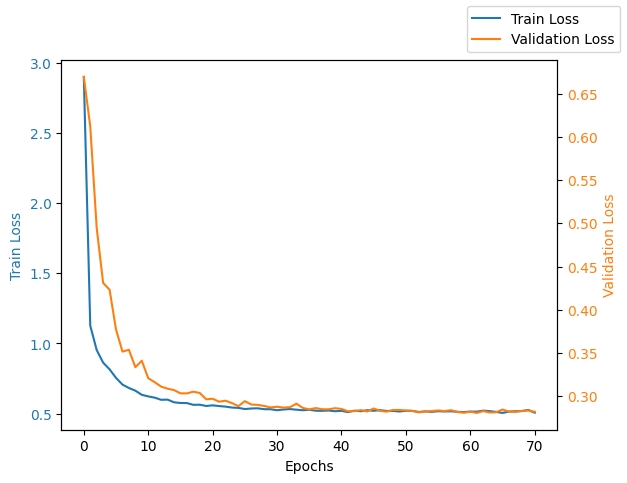

In [12]:
# Train the model
loss_criterion=DiceFocalHausdorffDTLoss(sigmoid=True, include_background=False, lambda_dfl=0.9, lambda_hausdorff=0.1)
best_model, _ = train(
    model=model,
    loss_criterion=loss_criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=100,
    patience=10,
    lr=1e-3,
    weight_decay=1e-3,
    l1_lambda=1e-4,
    max_grad_norm=1.0,
    gamma=0.90,
    show_output=True,
)

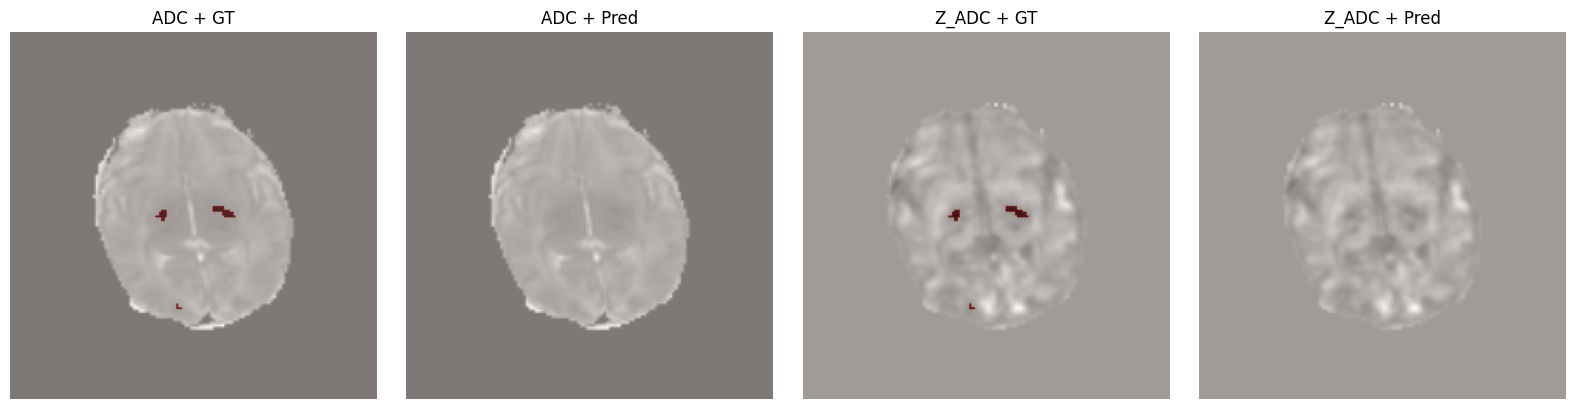

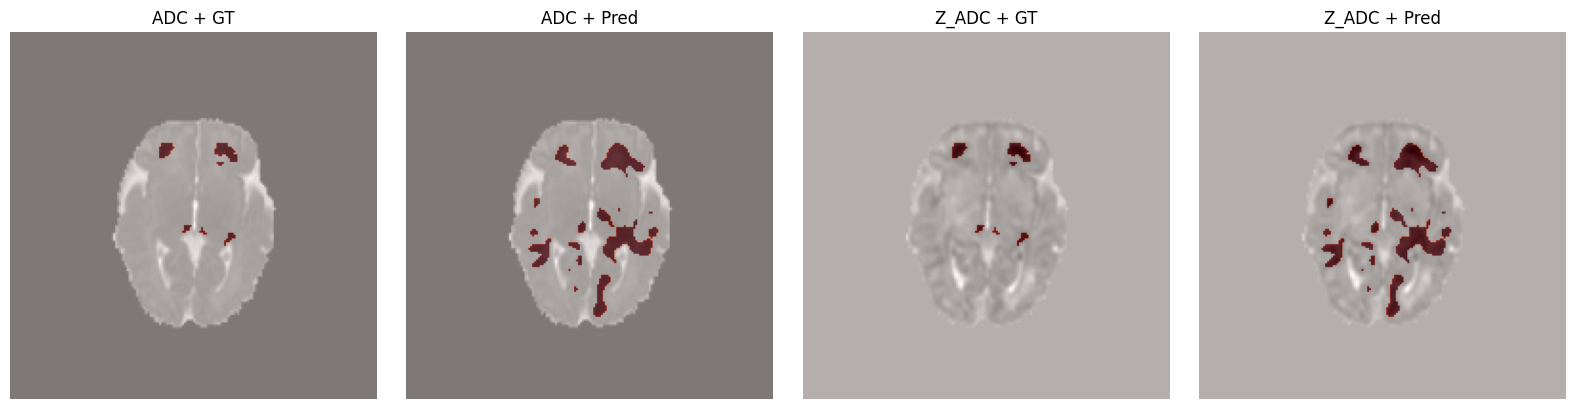

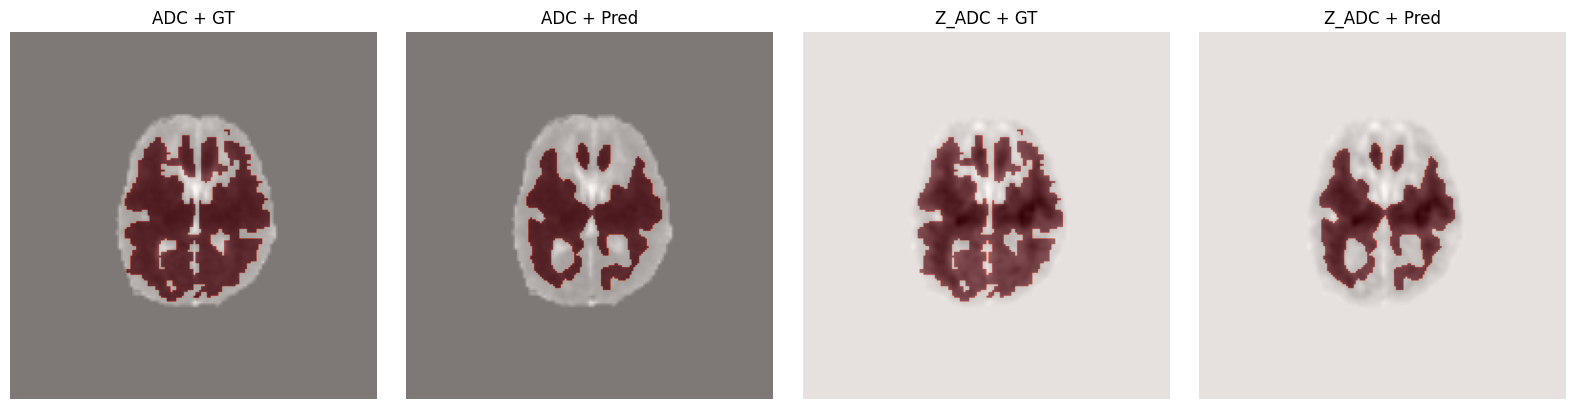

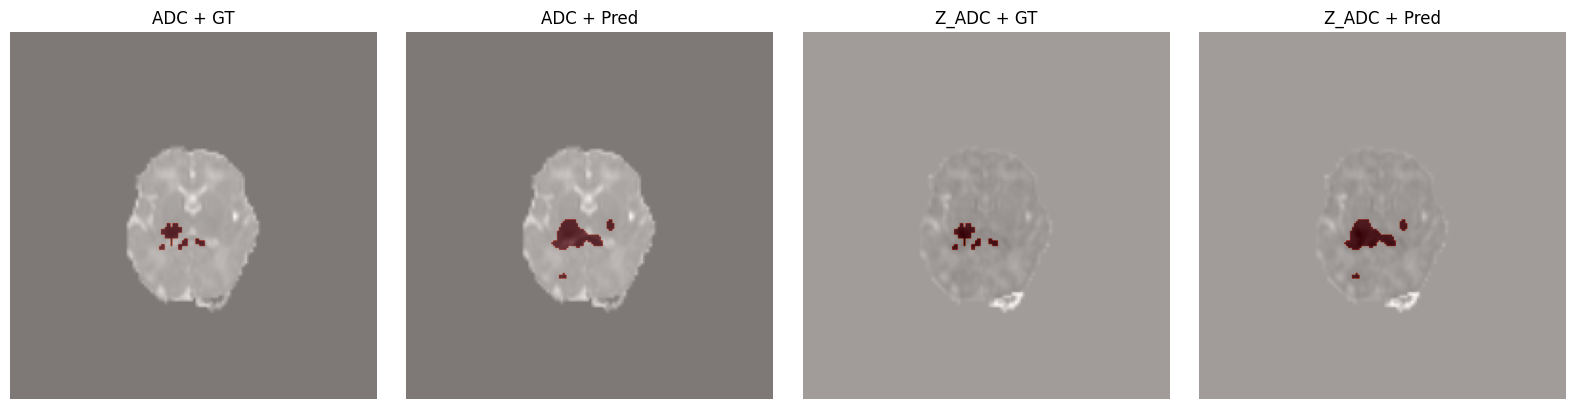

In [13]:
DFHDT_metrics_df=inference(best_model, val_loader)

In [16]:
DFHDT_metrics_df

DICE       MSD       NSD
Sample 1  0.262315  0.400899  0.379355
Sample 2  0.276351  3.491727  0.419879
Sample 3  0.779049  0.898031  0.548844
Sample 4  0.653860  0.896566  0.772835

### **Tversky+HausdorffDT Loss**

In [10]:
# Combined Loss Function
class TverskyHausdorffDTLoss(torch.nn.Module):
    def __init__(self, lambda_tv=1.0, lambda_hausdorff=1.0, include_background=False, sigmoid=True):
        super(TverskyHausdorffDTLoss, self).__init__()
        self.tv = TverskyLoss(
            include_background=include_background,
            sigmoid=sigmoid,
            alpha=0.3,
            beta=0.7
        )
        self.hausdorff = HausdorffDTLoss(
            sigmoid=sigmoid, include_background=include_background
        )
        self.lambda_tv = lambda_tv
        self.lambda_hausdorff = lambda_hausdorff

    def forward(self, prediction, target):
        tv_loss = self.tv(prediction, target)
        hausdorff_loss = self.hausdorff(prediction, target)
        log_hausdorff_loss = torch.log(1 + hausdorff_loss)

        total_loss = (
            self.lambda_tv * tv_loss + self.lambda_hausdorff * log_hausdorff_loss
        )
        return total_loss

In [11]:
# Reduced batch size due to memory constraints
# Create Datasets
train_dataset = BONBIDataset(train_maps_dir, train_label_dir, augment=True)
val_dataset = BONBIDataset(val_maps_dir, val_label_dir, augment=False)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=8)

Epoch 10 - Train Loss: 0.5632, Val Loss: 0.2802
Epoch 20 - Train Loss: 0.4922, Val Loss: 0.2477
Epoch 30 - Train Loss: 0.4666, Val Loss: 0.2411
Epoch 40 - Train Loss: 0.4584, Val Loss: 0.2336
Epoch 50 - Train Loss: 0.4613, Val Loss: 0.2332
Early stopping at epoch 59


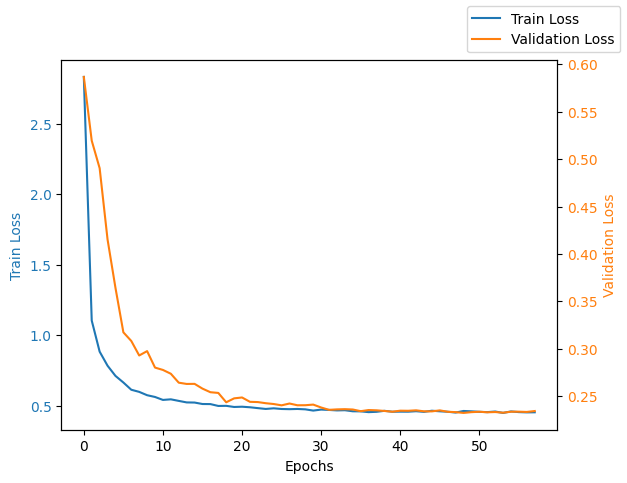

In [12]:
# Train the model
loss_criterion=TverskyHausdorffDTLoss(sigmoid=True, include_background=False, lambda_tv=0.9, lambda_hausdorff=0.1)
best_model, _ = train(
    model=model,
    loss_criterion=loss_criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=100,
    patience=10,
    lr=1e-3,
    weight_decay=1e-3,
    l1_lambda=1e-4,
    max_grad_norm=1.0,
    gamma=0.90,
    show_output=True,
)

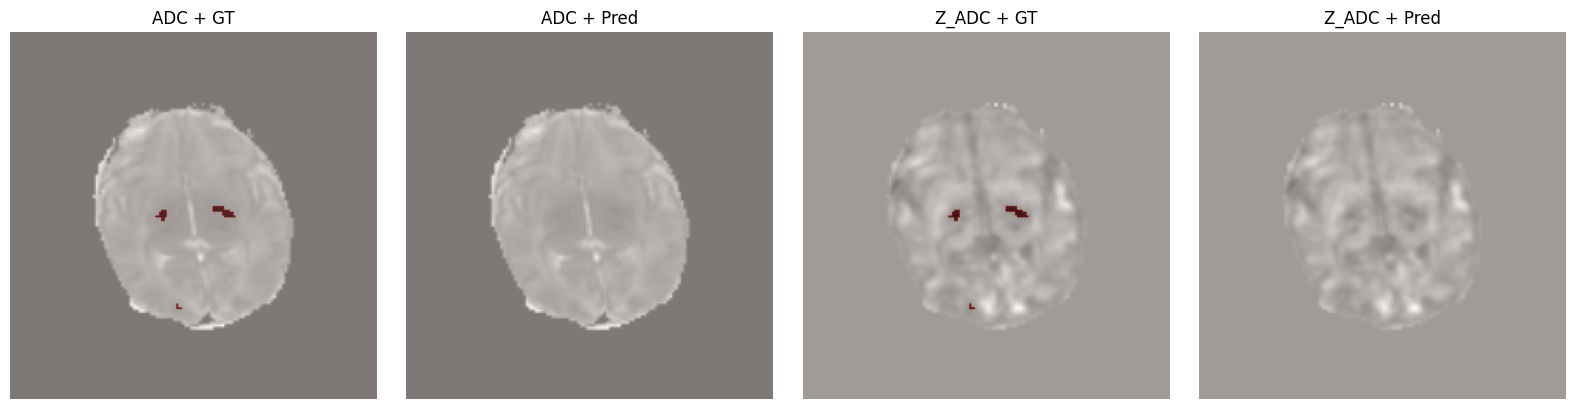

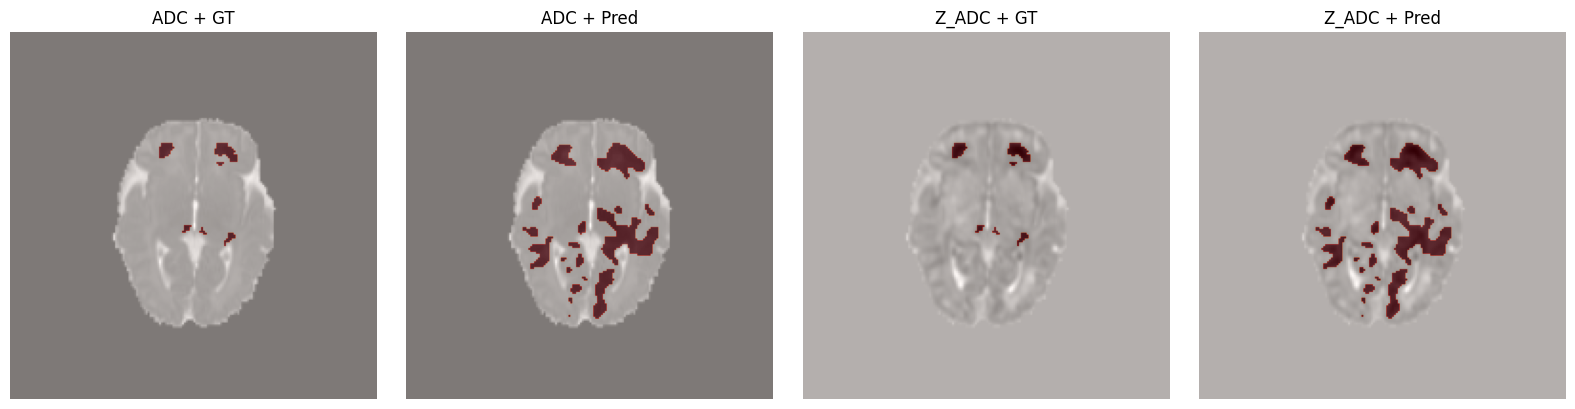

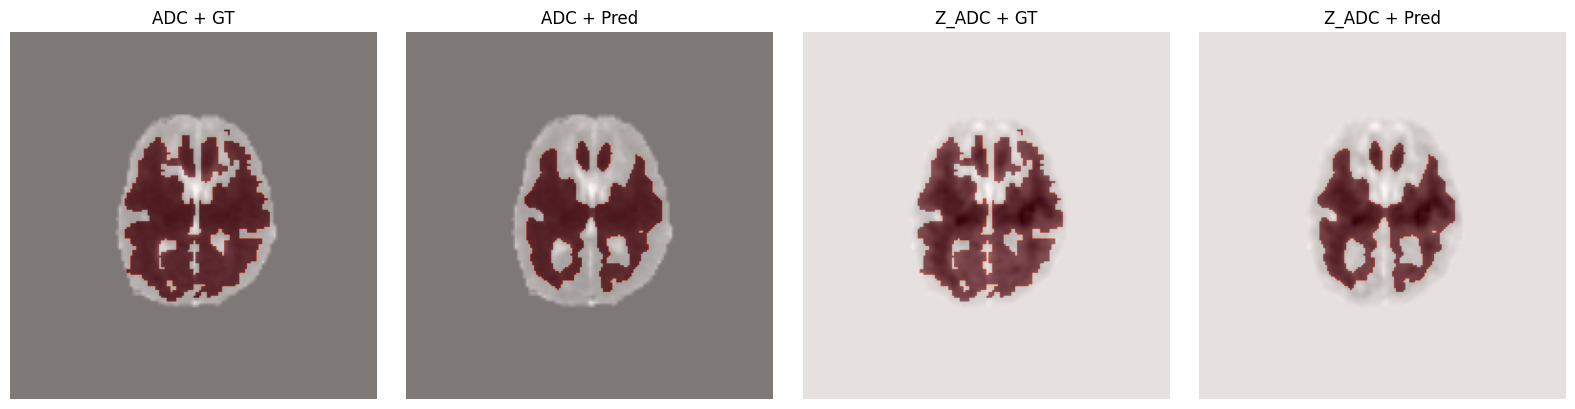

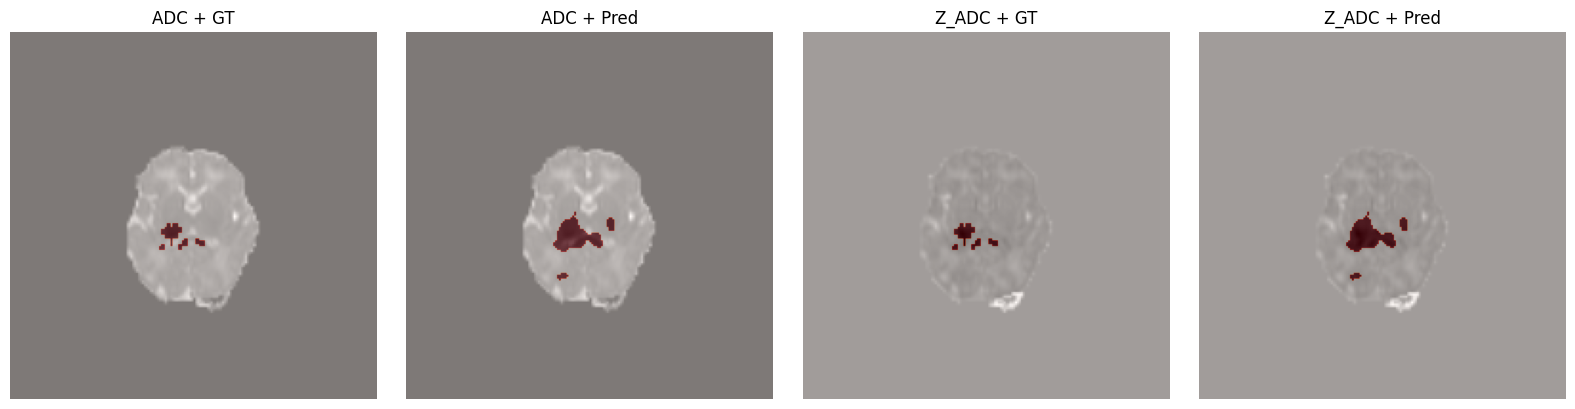

In [13]:
TvHDT_metrics_df=inference(best_model, val_loader)

In [16]:
TvHDT_metrics_df

DICE       MSD       NSD
Sample 1  0.347682  0.495335  0.477818
Sample 2  0.236235  3.991001  0.341322
Sample 3  0.808991  0.800937  0.623873
Sample 4  0.602305  1.208325  0.692959

## **Comparison**
We evaluate the segmentation quality using the following three metrics defined below:

* Mean Surface Distance (MSD): It computes the average distance between the surfaces of two binary masks, measuring how well the predicted and ground truth surfaces align. It considers both directions: from the prediction surface to the ground truth and vice versa.
* Normalized Surface Dice (NSD): NSD is a metric used to evaluate the similarity between the boundary surfaces of predicted and ground truth binary masks, allowing for a specified tolerance distance τ. It considers how many boundary points from the two masks fall within this distance, rather than requiring exact overlap. NSD provides a more flexible, surface-focused measure of accuracy, especially useful in scenarios where small boundary mismatches are acceptable.
* Dice coefficient: It measures the volumetric overlap between the prediction and ground truth masks.

### Metric Comparison

In [5]:
Data={'Dice':[np.mean([0.00,0.16,0.89,0.47]),np.mean([0.34,0.22,0.83,0.57]),np.mean([0.00,0.12,0.92,0.37]),
              np.mean([0.00,0.24,0.60,0.48]),np.mean([0.26,0.28,0.78,0.65]),np.mean([0.35,0.24,0.81,0.60])],
     'MSD':[np.mean([52.60,5.15,0.51,2.00]),np.mean([0.55,4.44,0.74,1.44]),np.mean([52.15,5.93,0.40,2.98]),
           np.mean([np.inf,1.22,1.44,0.52]),np.mean([0.40,3.49,0.90,0.90]),np.mean([0.50,3.99,0.80,1.21])],
     'NSD':[np.mean([0.01,0.22,0.81,0.50]),np.mean([0.47,0.32,0.67,0.65]),np.mean([0.01,0.14,0.87,0.33]),
           np.mean([0.00,0.34,0.24,0.54]),np.mean([0.38,0.42,0.55,0.77]),np.mean([0.48,0.34,0.62,0.69])],
     'Epochs':[32,49,38,29,72,59]}
Comp_df=pd.DataFrame(Data,index=['Dice Loss (Baseline)', 'Dice Focal Loss', 'Tversky Loss', 'HausdorffDT Loss',
                                 'DiceFocal-HausdorffDT Loss', 'Tversky-HausdorffDT Loss'])
Comp_df

Dice      MSD     NSD  Epochs
Dice Loss (Baseline)        0.3800  15.0650  0.3850      32
Dice Focal Loss             0.4900   1.7925  0.5275      49
Tversky Loss                0.3525  15.3650  0.3375      38
HausdorffDT Loss            0.3300      inf  0.2800      29
DiceFocal-HausdorffDT Loss  0.4925   1.4225  0.5300      72
Tversky-HausdorffDT Loss    0.5000   1.6250  0.5325      59

### Visual Comparison

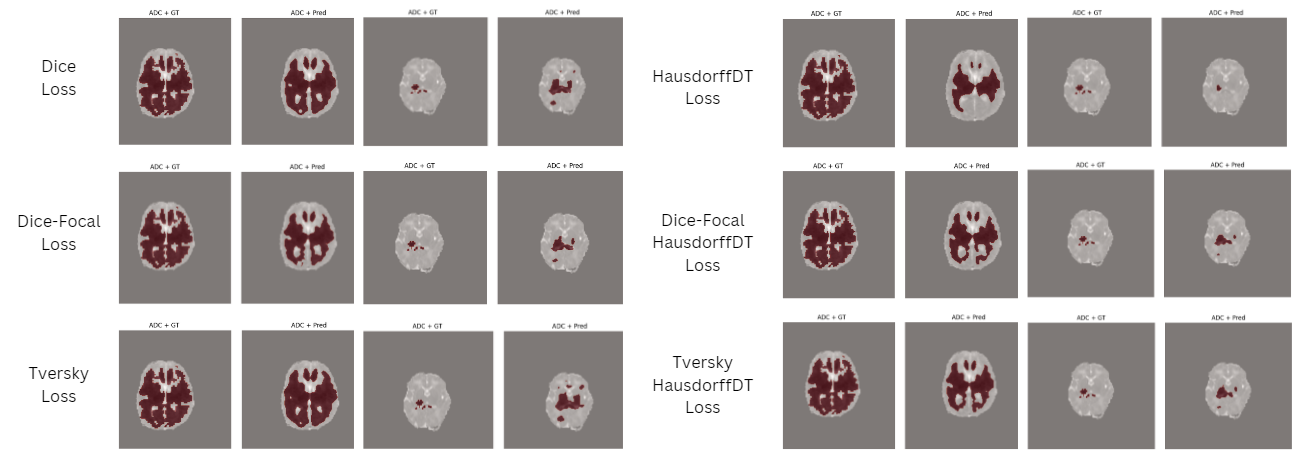

* The results indicate that combining losses yield superior performance than standalone loss functions.
* Dice-Focal loss reports great improvement over the baseline by a huge margin and understandably so as instead of just dice loss focusing on the overlap between predicted and ground truth regions that help in addressing lesions of varying sizes, focal loss specifically prioritizes hard-to-segment regions, such as smaller or less prominent lesions, over large, well-defined ones. This results in overall better performance.
* Hausdorff Distance Loss aims to provide more precise boundaries but, in doing so, it fails to capture complete lesion areas and sometimes misses small lesions altogether.
* In contrast, Tversky Loss performs well with large lesions and does not miss lesion areas but tends to over-segment, leading to poor performance with very small lesion sizes.
* Our defined hybrid losses, which aim to leverage the advantages of each individual loss function while mitigating their disadvantages, offer the best performance.
* Tversky-HausdorffDT Loss has the highest Dice and NSD metrics with second lowest MSD whereas DiceFocal-HausdorffDT Loss has the lowest MSD with second highest Dice and NSD metrics. Overall, Tversky-HausdorffDT Loss performs the best.
* These results are supported by both evaluation metrics and visualized masks on axial ADC maps.
* An interesting observation is that all combination losses require more epochs to converge compared to the standalone losses.

## **Conclusion**
In this study, we aimed to improve HIE lesion segmentation through loss function optimization and our proposed hybrid loss functions achieved the best Dice, MSD, and NSD metrics.

### **Limitations**
However, despite achieving improvements with hybrid losses as hypothesized, this study has several limitations:

* None of the defined losses did well on extremely small lesions (<1% volume) due to high heterogeneity in the dataset and limited capability of the model itself.
* Only the validation set itself is used for evaluation since the test set is held out by the organizers as the dataset is part of BONBID-HIE Challenge 2024 and evaluation on test set require submitting a Docker container to the online platform by the organizers. The performance on the validation set may not reflect the true capability of the methodology defined here.
* Resampled label mask could introduce distortion in segmentation regions in comparison to the actual mask. A more robust approach would be to only resample maps to a fixed size and reverse resample the predicted binary masks to original size, spacing, direction, and origin for true comparison with the actual label mask.

### **Future Work**
* Loss function optimization improves the segmentation performance and while this will direct research towards defining a custom loss function for HIE lesions, the improvement is expected to be marginal only. It would be better to define a custom loss function in relation to more advance architectures.
* The main challenge in this problem lies in the data itself, which is highly limited for training any model with strong capabilities. A better approach would be to avoid training altogether and instead use models like SAM, which offer zero-shot generalizability. Specifically, MedSAM-2, which is already fine-tuned on medical imaging, would be ideal. From [3] we know that negative intensities in ZADC maps are correlated with lesion regions. Therefore, we can prompt MedSAM-2 with bounding boxes around negative intensities in ZADC maps and provide ADC maps as input for segmentation.